In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
import logging

def get_logger(file_path):
    logger = logging.getLogger()
    log_format = '%(asctime)s | %(message)s'
    formatter = logging.Formatter(log_format, datefmt='%m/%d %I:%M:%S %p')
    file_handler = logging.FileHandler(file_path)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)

    return logger

log_name = '{}'.format(time.strftime("%m%d-%H%M"))
log_path = './log'+'/'+log_name
if not os.path.isdir('log'):
    os.mkdir('log')
if not os.path.isdir(log_path):
    os.mkdir(log_path)
logger = get_logger(os.path.join(log_path, "{}.log".format(log_name)))

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
seed = 777

def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
make_reproducible(seed)

In [40]:
path2csv = './testtest.csv'
df = pd.read_csv(path2csv)
df.tail()
# DB01100 DB00243 DB00572 DB00776  DB03615 0
# DB09161 DB08930 DB00530 DB00426 DB01268 1

,Y,filepath,id,smiles
1413,1,./images/DB09161.jpg,DB09161,CC(C)(C)NC[C@H](O)COC1=CC=CC2=C1CCCC2=O
1414,1,./images/DB08930.jpg,DB08930,ClC1=CC(Cl)=C(C=C1)C(CN1C=CN=C1)OCC1=CSC2=C1C=...
1415,1,./images/DB00530.jpg,DB00530,[H][C@@]1(C)CCN(C[C@]1([H])N(C)C1=NC=NC2=C1C=C...
1416,1,./images/DB00426.jpg,DB00426,CN1C2=CC=CC=C2C(NCCCCCCC(O)=O)C2=C(C=C(Cl)C=C2...
1417,1,./images/DB01268.jpg,DB01268,[H][C@]12SCC(CSC3=NN=NN3C)=C(N1C(=O)[C@@]2([H]...


In [7]:
df.iloc[1, 1][9:]

'DB00243.jpg'

In [8]:
df['Y'].value_counts()

0    991
1    427
Name: Y, dtype: int64

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './images/'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = './thick_images/' + self.metadata.iloc[idx, 1][9:]
        image = Image.open(img_name)
        label = self.metadata.iloc[idx, 0]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [14]:
im_size = 224
train_dataset = CustomDataset(df,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomRotation(45),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [15]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)

In [16]:
#! pip install Pillow==5.2.0

11/27 02:42:10 AM | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


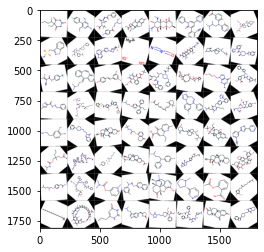

tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])


In [17]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)

images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(features)

In [18]:
import torchvision.models as models
model = models.resnet18(pretrained = True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

model = model.to(device)

In [19]:
num_epochs = 50
learning_rate = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [23]:
def train(model, train_loader, optimizer, logger, log_interval):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
#        print(gt.shape)
#        print(preds.shape)

        loss = loss_func(outputs, gt)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == gt.data)
        run_cnt += len(gt)
        
        if i % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(i*batch_size, 
                                                               len(train_loader.dataset),
                                                               100.*i / num_of_mini_batch,
                                                               loss.item()))
            #torch.save(model.state_dict(), './my_weights.pth')
        
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    logger.info('train loss: %.4f, train acc: %.4f' %(cost, acc))
    torch.save(model.state_dict(), './new_weights.pth')

In [24]:
train_loss_list = []
train_acc_list = []

for i in range(num_epochs):
    logger.info("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, train_loader, opt, logger, log_interval = 6)
    #print('-'*20,'TEST','-'*20)
#    test(model, test_loader, opt, logger)
    scheduler.step()

11/27 02:42:33 AM | ==================== EPOCH :  0 ====================


[0/1418](0%)   Train Loss : 0.674716 
[384/1418](26%)   Train Loss : 0.713547 
[768/1418](52%)   Train Loss : 0.625490 
[1152/1418](78%)   Train Loss : 0.592286 


11/27 02:50:05 AM | train loss: 0.7562, train acc: 65.3738
11/27 02:50:05 AM | ==================== EPOCH :  1 ====================


[0/1418](0%)   Train Loss : 0.532785 
[384/1418](26%)   Train Loss : 0.571920 
[768/1418](52%)   Train Loss : 0.653603 
[1152/1418](78%)   Train Loss : 0.557266 


11/27 02:57:41 AM | train loss: 0.6194, train acc: 69.1114
11/27 02:57:41 AM | ==================== EPOCH :  2 ====================


[0/1418](0%)   Train Loss : 0.628934 
[384/1418](26%)   Train Loss : 0.615953 
[768/1418](52%)   Train Loss : 0.504770 
[1152/1418](78%)   Train Loss : 0.594421 


11/27 03:05:11 AM | train loss: 0.6096, train acc: 69.5346
11/27 03:05:11 AM | ==================== EPOCH :  3 ====================


[0/1418](0%)   Train Loss : 0.515252 
[384/1418](26%)   Train Loss : 0.612309 
[768/1418](52%)   Train Loss : 0.568993 
[1152/1418](78%)   Train Loss : 0.579645 


11/27 03:12:41 AM | train loss: 0.5958, train acc: 70.2398
11/27 03:12:41 AM | ==================== EPOCH :  4 ====================


[0/1418](0%)   Train Loss : 0.538547 
[384/1418](26%)   Train Loss : 0.493994 
[768/1418](52%)   Train Loss : 0.587318 
[1152/1418](78%)   Train Loss : 0.650481 


11/27 03:20:13 AM | train loss: 0.5894, train acc: 68.6178
11/27 03:20:13 AM | ==================== EPOCH :  5 ====================


[0/1418](0%)   Train Loss : 0.704198 
[384/1418](26%)   Train Loss : 0.606098 
[768/1418](52%)   Train Loss : 0.621861 
[1152/1418](78%)   Train Loss : 0.480069 


11/27 03:27:44 AM | train loss: 0.5760, train acc: 70.5924
11/27 03:27:44 AM | ==================== EPOCH :  6 ====================


[0/1418](0%)   Train Loss : 0.681194 
[384/1418](26%)   Train Loss : 0.642631 
[768/1418](52%)   Train Loss : 0.668111 
[1152/1418](78%)   Train Loss : 0.566314 


11/27 03:35:16 AM | train loss: 0.5811, train acc: 70.3808
11/27 03:35:16 AM | ==================== EPOCH :  7 ====================


[0/1418](0%)   Train Loss : 0.504890 
[384/1418](26%)   Train Loss : 0.582565 
[768/1418](52%)   Train Loss : 0.648291 
[1152/1418](78%)   Train Loss : 0.588454 


11/27 03:42:49 AM | train loss: 0.5701, train acc: 71.1566
11/27 03:42:49 AM | ==================== EPOCH :  8 ====================


[0/1418](0%)   Train Loss : 0.513707 
[384/1418](26%)   Train Loss : 0.518918 
[768/1418](52%)   Train Loss : 0.544444 
[1152/1418](78%)   Train Loss : 0.567786 


11/27 03:50:20 AM | train loss: 0.5704, train acc: 70.0987
11/27 03:50:20 AM | ==================== EPOCH :  9 ====================


[0/1418](0%)   Train Loss : 0.513967 
[384/1418](26%)   Train Loss : 0.527766 
[768/1418](52%)   Train Loss : 0.585416 
[1152/1418](78%)   Train Loss : 0.556960 


11/27 03:57:51 AM | train loss: 0.5649, train acc: 69.5346
11/27 03:57:51 AM | ==================== EPOCH :  10 ====================


[0/1418](0%)   Train Loss : 0.483473 
[384/1418](26%)   Train Loss : 0.482715 
[768/1418](52%)   Train Loss : 0.560485 
[1152/1418](78%)   Train Loss : 0.641471 


11/27 04:05:22 AM | train loss: 0.5513, train acc: 69.8166
11/27 04:05:22 AM | ==================== EPOCH :  11 ====================


[0/1418](0%)   Train Loss : 0.527463 
[384/1418](26%)   Train Loss : 0.527826 
[768/1418](52%)   Train Loss : 0.439581 
[1152/1418](78%)   Train Loss : 0.565210 


11/27 04:12:56 AM | train loss: 0.5416, train acc: 72.0028
11/27 04:12:56 AM | ==================== EPOCH :  12 ====================


[0/1418](0%)   Train Loss : 0.482252 
[384/1418](26%)   Train Loss : 0.575882 
[768/1418](52%)   Train Loss : 0.584184 
[1152/1418](78%)   Train Loss : 0.495689 


11/27 04:20:28 AM | train loss: 0.5536, train acc: 70.9450
11/27 04:20:28 AM | ==================== EPOCH :  13 ====================


[0/1418](0%)   Train Loss : 0.634104 
[384/1418](26%)   Train Loss : 0.572135 
[768/1418](52%)   Train Loss : 0.544106 
[1152/1418](78%)   Train Loss : 0.635543 


11/27 04:28:00 AM | train loss: 0.5226, train acc: 74.0480
11/27 04:28:01 AM | ==================== EPOCH :  14 ====================


[0/1418](0%)   Train Loss : 0.452482 
[384/1418](26%)   Train Loss : 0.530207 
[768/1418](52%)   Train Loss : 0.623436 
[1152/1418](78%)   Train Loss : 0.569461 


11/27 04:35:33 AM | train loss: 0.5277, train acc: 72.4260
11/27 04:35:33 AM | ==================== EPOCH :  15 ====================


[0/1418](0%)   Train Loss : 0.461229 
[384/1418](26%)   Train Loss : 0.457681 
[768/1418](52%)   Train Loss : 0.588947 
[1152/1418](78%)   Train Loss : 0.621986 


11/27 04:43:05 AM | train loss: 0.5438, train acc: 71.0155
11/27 04:43:05 AM | ==================== EPOCH :  16 ====================


[0/1418](0%)   Train Loss : 0.488748 
[384/1418](26%)   Train Loss : 0.655384 
[768/1418](52%)   Train Loss : 0.518132 
[1152/1418](78%)   Train Loss : 0.480383 


11/27 04:50:37 AM | train loss: 0.5274, train acc: 72.7080
11/27 04:50:37 AM | ==================== EPOCH :  17 ====================


[0/1418](0%)   Train Loss : 0.554973 
[384/1418](26%)   Train Loss : 0.502923 
[768/1418](52%)   Train Loss : 0.490335 
[1152/1418](78%)   Train Loss : 0.474573 


11/27 04:58:09 AM | train loss: 0.4820, train acc: 74.9647
11/27 04:58:09 AM | ==================== EPOCH :  18 ====================


[0/1418](0%)   Train Loss : 0.354192 
[384/1418](26%)   Train Loss : 0.519764 
[768/1418](52%)   Train Loss : 0.463465 
[1152/1418](78%)   Train Loss : 0.643797 


11/27 05:05:41 AM | train loss: 0.5095, train acc: 74.4006
11/27 05:05:41 AM | ==================== EPOCH :  19 ====================


[0/1418](0%)   Train Loss : 0.528766 
[384/1418](26%)   Train Loss : 0.385515 
[768/1418](52%)   Train Loss : 0.578007 
[1152/1418](78%)   Train Loss : 0.428956 


11/27 05:13:16 AM | train loss: 0.4884, train acc: 76.0226
11/27 05:13:16 AM | ==================== EPOCH :  20 ====================


[0/1418](0%)   Train Loss : 0.438663 
[384/1418](26%)   Train Loss : 0.484211 
[768/1418](52%)   Train Loss : 0.342233 
[1152/1418](78%)   Train Loss : 0.478322 


11/27 05:20:43 AM | train loss: 0.4524, train acc: 78.6319
11/27 05:20:43 AM | ==================== EPOCH :  21 ====================


[0/1418](0%)   Train Loss : 0.339149 
[384/1418](26%)   Train Loss : 0.583773 
[768/1418](52%)   Train Loss : 0.319937 
[1152/1418](78%)   Train Loss : 0.454311 


11/27 05:28:12 AM | train loss: 0.4408, train acc: 79.1255
11/27 05:28:12 AM | ==================== EPOCH :  22 ====================


[0/1418](0%)   Train Loss : 0.389748 
[384/1418](26%)   Train Loss : 0.336732 
[768/1418](52%)   Train Loss : 0.478235 
[1152/1418](78%)   Train Loss : 0.406899 


11/27 05:35:41 AM | train loss: 0.4153, train acc: 81.1001
11/27 05:35:41 AM | ==================== EPOCH :  23 ====================


[0/1418](0%)   Train Loss : 0.436336 
[384/1418](26%)   Train Loss : 0.302116 
[768/1418](52%)   Train Loss : 0.450556 
[1152/1418](78%)   Train Loss : 0.400049 


11/27 05:43:11 AM | train loss: 0.3885, train acc: 81.6643
11/27 05:43:11 AM | ==================== EPOCH :  24 ====================


[0/1418](0%)   Train Loss : 0.385497 
[384/1418](26%)   Train Loss : 0.413454 
[768/1418](52%)   Train Loss : 0.419064 
[1152/1418](78%)   Train Loss : 0.436112 


11/27 05:50:43 AM | train loss: 0.3901, train acc: 83.3568
11/27 05:50:43 AM | ==================== EPOCH :  25 ====================


[0/1418](0%)   Train Loss : 0.362584 
[384/1418](26%)   Train Loss : 0.327715 
[768/1418](52%)   Train Loss : 0.313789 
[1152/1418](78%)   Train Loss : 0.421695 


11/27 05:58:13 AM | train loss: 0.3645, train acc: 84.1326
11/27 05:58:13 AM | ==================== EPOCH :  26 ====================


[0/1418](0%)   Train Loss : 0.227720 
[384/1418](26%)   Train Loss : 0.280531 
[768/1418](52%)   Train Loss : 0.342072 
[1152/1418](78%)   Train Loss : 0.372630 


11/27 06:05:45 AM | train loss: 0.3225, train acc: 86.2482
11/27 06:05:45 AM | ==================== EPOCH :  27 ====================


[0/1418](0%)   Train Loss : 0.298310 
[384/1418](26%)   Train Loss : 0.429325 
[768/1418](52%)   Train Loss : 0.506517 
[1152/1418](78%)   Train Loss : 0.398043 


11/27 06:13:16 AM | train loss: 0.3340, train acc: 85.6135
11/27 06:13:16 AM | ==================== EPOCH :  28 ====================


[0/1418](0%)   Train Loss : 0.396304 
[384/1418](26%)   Train Loss : 0.264639 
[768/1418](52%)   Train Loss : 0.231849 
[1152/1418](78%)   Train Loss : 0.367259 


11/27 06:20:45 AM | train loss: 0.3175, train acc: 85.7546
11/27 06:20:45 AM | ==================== EPOCH :  29 ====================


[0/1418](0%)   Train Loss : 0.350715 
[384/1418](26%)   Train Loss : 0.247003 
[768/1418](52%)   Train Loss : 0.289557 
[1152/1418](78%)   Train Loss : 0.280492 


11/27 06:28:16 AM | train loss: 0.2933, train acc: 87.7997
11/27 06:28:16 AM | ==================== EPOCH :  30 ====================


[0/1418](0%)   Train Loss : 0.316689 
[384/1418](26%)   Train Loss : 0.449946 
[768/1418](52%)   Train Loss : 0.200825 
[1152/1418](78%)   Train Loss : 0.335301 


11/27 06:35:47 AM | train loss: 0.2718, train acc: 88.2934
11/27 06:35:47 AM | ==================== EPOCH :  31 ====================


[0/1418](0%)   Train Loss : 0.220704 
[384/1418](26%)   Train Loss : 0.200670 
[768/1418](52%)   Train Loss : 0.120720 
[1152/1418](78%)   Train Loss : 0.296206 


11/27 06:43:19 AM | train loss: 0.2235, train acc: 90.6206
11/27 06:43:19 AM | ==================== EPOCH :  32 ====================


[0/1418](0%)   Train Loss : 0.281314 
[384/1418](26%)   Train Loss : 0.144249 
[768/1418](52%)   Train Loss : 0.372447 
[1152/1418](78%)   Train Loss : 0.147115 


11/27 06:50:51 AM | train loss: 0.2352, train acc: 90.9027
11/27 06:50:51 AM | ==================== EPOCH :  33 ====================


[0/1418](0%)   Train Loss : 0.246188 
[384/1418](26%)   Train Loss : 0.107949 
[768/1418](52%)   Train Loss : 0.240440 
[1152/1418](78%)   Train Loss : 0.243924 


11/27 06:58:21 AM | train loss: 0.2335, train acc: 90.4795
11/27 06:58:21 AM | ==================== EPOCH :  34 ====================


[0/1418](0%)   Train Loss : 0.139092 
[384/1418](26%)   Train Loss : 0.163455 
[768/1418](52%)   Train Loss : 0.299663 
[1152/1418](78%)   Train Loss : 0.171291 


11/27 07:05:54 AM | train loss: 0.2335, train acc: 91.3963
11/27 07:05:54 AM | ==================== EPOCH :  35 ====================


[0/1418](0%)   Train Loss : 0.148145 
[384/1418](26%)   Train Loss : 0.096096 
[768/1418](52%)   Train Loss : 0.214399 
[1152/1418](78%)   Train Loss : 0.192713 


11/27 07:13:23 AM | train loss: 0.2061, train acc: 92.1016
11/27 07:13:23 AM | ==================== EPOCH :  36 ====================


[0/1418](0%)   Train Loss : 0.111451 
[384/1418](26%)   Train Loss : 0.138364 
[768/1418](52%)   Train Loss : 0.218643 
[1152/1418](78%)   Train Loss : 0.153151 


11/27 07:20:53 AM | train loss: 0.1863, train acc: 92.8068
11/27 07:20:53 AM | ==================== EPOCH :  37 ====================


[0/1418](0%)   Train Loss : 0.226634 
[384/1418](26%)   Train Loss : 0.170155 
[768/1418](52%)   Train Loss : 0.155687 
[1152/1418](78%)   Train Loss : 0.232416 


11/27 07:28:24 AM | train loss: 0.2042, train acc: 92.9478
11/27 07:28:24 AM | ==================== EPOCH :  38 ====================


[0/1418](0%)   Train Loss : 0.137191 
[384/1418](26%)   Train Loss : 0.089252 
[768/1418](52%)   Train Loss : 0.154094 
[1152/1418](78%)   Train Loss : 0.171051 


11/27 07:35:53 AM | train loss: 0.1630, train acc: 94.0056
11/27 07:35:53 AM | ==================== EPOCH :  39 ====================


[0/1418](0%)   Train Loss : 0.079641 
[384/1418](26%)   Train Loss : 0.211148 
[768/1418](52%)   Train Loss : 0.070486 
[1152/1418](78%)   Train Loss : 0.178529 


11/27 07:43:23 AM | train loss: 0.1363, train acc: 94.7814
11/27 07:43:23 AM | ==================== EPOCH :  40 ====================


[0/1418](0%)   Train Loss : 0.139040 
[384/1418](26%)   Train Loss : 0.233818 
[768/1418](52%)   Train Loss : 0.083814 
[1152/1418](78%)   Train Loss : 0.140383 


11/27 07:50:51 AM | train loss: 0.1791, train acc: 93.5120
11/27 07:50:51 AM | ==================== EPOCH :  41 ====================


[0/1418](0%)   Train Loss : 0.084211 
[384/1418](26%)   Train Loss : 0.163139 
[768/1418](52%)   Train Loss : 0.127505 
[1152/1418](78%)   Train Loss : 0.102405 


11/27 07:58:18 AM | train loss: 0.1501, train acc: 94.8519
11/27 07:58:18 AM | ==================== EPOCH :  42 ====================


[0/1418](0%)   Train Loss : 0.121116 
[384/1418](26%)   Train Loss : 0.230120 
[768/1418](52%)   Train Loss : 0.142370 
[1152/1418](78%)   Train Loss : 0.179691 


11/27 08:05:47 AM | train loss: 0.1540, train acc: 94.2877
11/27 08:05:47 AM | ==================== EPOCH :  43 ====================


[0/1418](0%)   Train Loss : 0.170091 
[384/1418](26%)   Train Loss : 0.055178 
[768/1418](52%)   Train Loss : 0.150312 
[1152/1418](78%)   Train Loss : 0.086226 


11/27 08:13:16 AM | train loss: 0.1508, train acc: 94.8519
11/27 08:13:16 AM | ==================== EPOCH :  44 ====================


[0/1418](0%)   Train Loss : 0.081509 
[384/1418](26%)   Train Loss : 0.104543 
[768/1418](52%)   Train Loss : 0.142924 
[1152/1418](78%)   Train Loss : 0.065307 


11/27 08:20:43 AM | train loss: 0.1227, train acc: 95.0635
11/27 08:20:43 AM | ==================== EPOCH :  45 ====================


[0/1418](0%)   Train Loss : 0.030100 
[384/1418](26%)   Train Loss : 0.074806 
[768/1418](52%)   Train Loss : 0.142676 
[1152/1418](78%)   Train Loss : 0.194817 


11/27 08:28:12 AM | train loss: 0.1507, train acc: 94.9929
11/27 08:28:12 AM | ==================== EPOCH :  46 ====================


[0/1418](0%)   Train Loss : 0.163276 
[384/1418](26%)   Train Loss : 0.118831 
[768/1418](52%)   Train Loss : 0.087712 
[1152/1418](78%)   Train Loss : 0.109708 


11/27 08:35:40 AM | train loss: 0.1334, train acc: 94.9224
11/27 08:35:40 AM | ==================== EPOCH :  47 ====================


[0/1418](0%)   Train Loss : 0.117903 
[384/1418](26%)   Train Loss : 0.076066 
[768/1418](52%)   Train Loss : 0.049693 
[1152/1418](78%)   Train Loss : 0.195793 


11/27 08:43:08 AM | train loss: 0.1248, train acc: 95.3456
11/27 08:43:08 AM | ==================== EPOCH :  48 ====================


[0/1418](0%)   Train Loss : 0.063573 
[384/1418](26%)   Train Loss : 0.058507 
[768/1418](52%)   Train Loss : 0.227077 
[1152/1418](78%)   Train Loss : 0.116017 


11/27 08:50:37 AM | train loss: 0.1157, train acc: 95.5571
11/27 08:50:37 AM | ==================== EPOCH :  49 ====================


[0/1418](0%)   Train Loss : 0.084615 
[384/1418](26%)   Train Loss : 0.158028 
[768/1418](52%)   Train Loss : 0.180735 
[1152/1418](78%)   Train Loss : 0.061533 


11/27 08:58:07 AM | train loss: 0.1083, train acc: 95.2750


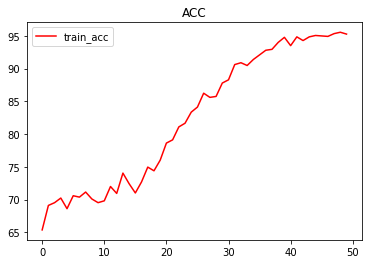

In [25]:
plt.plot(train_acc_list, 'r', label = 'train_acc')
plt.title('ACC')
plt.legend()
plt.show()

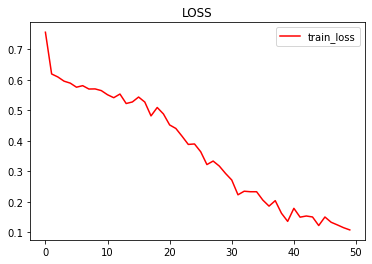

In [26]:
plt.plot(train_loss_list, 'r', label = 'train_loss')
plt.title('LOSS')
plt.legend()
plt.show()

# Visualization

In [32]:
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [28]:
model.eval()
cam_extractor = SmoothGradCAMpp(model)

11/27 08:58:07 AM | no value was provided for `target_layer`, thus set to 'layer4'.


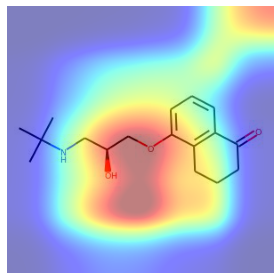

In [41]:
# DB09161 DB08930 DB00530 DB00426 DB01268
img = read_image("./images/DB09161.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

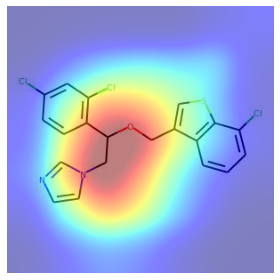

In [42]:
# DB09161 DB08930 DB00530 DB00426 DB01268
img = read_image("./images/DB08930.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

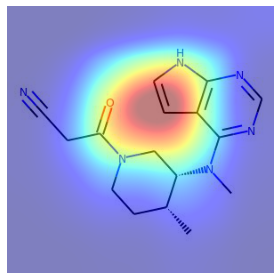

In [43]:
# DB09161 DB08930 DB00530 DB00426 DB01268
img = read_image("./images/DB00530.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

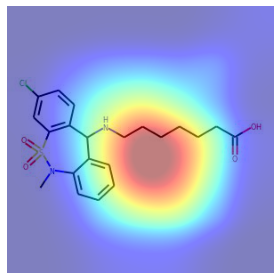

In [44]:
# DB09161 DB08930 DB00530 DB00426 DB01268
img = read_image("./images/DB00426.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

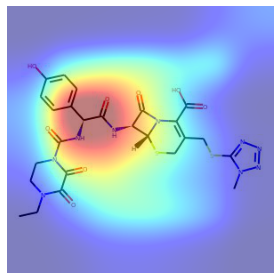

In [54]:
# DB09161 DB08930 DB00530 DB00426 DB01268
img = read_image("./images/DB01268.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()